# Курсовой проект по курсу PyTorch: 2-я модель классификатора

Ссылка на датасет: https://www.kaggle.com/toxicmender/20bn-jester

## Подключение библиотек и загрузка датасета

In [1]:
%matplotlib inline
!pip install mediapipe
import os
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import pandas as pd
import time
import cv2
from torch.nn import functional as F
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from google.colab import files
from google.colab.patches import cv2_imshow
import mediapipe as mp

     |████████████████████████████████| 35.0MB 96kB/s 
     |████████████████████████████████| 14.9MB 146kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


In [635]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d toxicmender/20bn-jester
!unzip -q /content/20bn-jester.zip -d /content/20bn-jester

100% 11.9G/11.9G [04:51<00:00, 122MB/s] 
100% 11.9G/11.9G [04:51<00:00, 43.9MB/s]


## Подготовка данных для датасета

In [5]:
train = pd.read_csv('/content/20bn-jester/Train.csv')
validatioon = pd.read_csv('/content/20bn-jester/Validation.csv')
test = pd.read_csv('/content/20bn-jester/Test.csv')

In [6]:
train.head()

,video_id,label,frames,label_id,shape,format
0,1,Doing other things,37,0,"(100, 176)",JPEG
1,3,Pushing Two Fingers Away,37,6,"(100, 176)",JPEG
2,6,Drumming Fingers,37,1,"(100, 176)",JPEG
3,11,Sliding Two Fingers Down,37,10,"(100, 176)",JPEG
4,14,Pushing Hand Away,37,5,"(100, 176)",JPEG


In [7]:
train['label_id'].unique()

array([ 0,  6,  1, 10,  5,  9,  4, 14, 24, 13, 26, 23,  2, 17, 19,  8,  3,
       25, 16,  7, 22, 18, 21, 11, 15, 20, 12])

In [8]:
train['shape'].unique()

array(['(100, 176)', '(100, 132)', '(100, 100)', '(100, 142)',
       '(100, 122)', '(100, 172)'], dtype=object)

In [9]:
# df дляотображения label_id в label
label_id_to_label = train[['label', 'label_id']]
label_id_to_label = label_id_to_label.drop_duplicates()
label_id_to_label.index = label_id_to_label['label_id']
label_id_to_label = label_id_to_label.drop(columns = ['label_id'])
label_id_to_label = label_id_to_label.sort_index()
label_id_to_label

,label
label_id,
0,Doing other things
1,Drumming Fingers
2,No gesture
3,Pulling Hand In
4,Pulling Two Fingers In
5,Pushing Hand Away
6,Pushing Two Fingers Away
7,Rolling Hand Backward
8,Rolling Hand Forward


In [10]:
label_id_to_label.iloc[0].values[0]

'Doing other things'

In [11]:
# Добавим колонку с адресами видео (последовательность фото)
train['video_addr'] = train['video_id'].apply(lambda x: '/content/20bn-jester/Train/' + str(x))

In [12]:
# Функция возвращает список адресов фото для данного видео
def get_image_addrs(video_addr):
  image_addrs = []
  for i in range(4, 36, 1):
    addr = '0000' + str(i)
    addr = addr[-5:]
    addr = video_addr + '/' + addr + '.jpg'
    image_addrs.append(addr)
  return image_addrs

In [13]:
# Добавим колонку с адресами кадров данного видео
train['image_addrs'] = train['video_addr'].apply(lambda x: get_image_addrs(x))

In [14]:
# Возьмем только первые 3 класса для быстрого проведения экспериментов
train = train[train['label_id'].isin([0,1,2])]
train.reset_index(inplace=True)
train.drop(columns=['index'], inplace=True)

In [15]:
train.head()

,video_id,label,frames,label_id,shape,format,video_addr,image_addrs
0,1,Doing other things,37,0,"(100, 176)",JPEG,/content/20bn-jester/Train/1,"[/content/20bn-jester/Train/1/00004.jpg, /cont..."
1,6,Drumming Fingers,37,1,"(100, 176)",JPEG,/content/20bn-jester/Train/6,"[/content/20bn-jester/Train/6/00004.jpg, /cont..."
2,20,Doing other things,37,0,"(100, 176)",JPEG,/content/20bn-jester/Train/20,"[/content/20bn-jester/Train/20/00004.jpg, /con..."
3,50,No gesture,37,2,"(100, 176)",JPEG,/content/20bn-jester/Train/50,"[/content/20bn-jester/Train/50/00004.jpg, /con..."
4,70,No gesture,37,2,"(100, 176)",JPEG,/content/20bn-jester/Train/70,"[/content/20bn-jester/Train/70/00004.jpg, /con..."


In [16]:
train.shape

(8036, 8)

In [17]:
train['image_addrs'][0]

['/content/20bn-jester/Train/1/00004.jpg',
 '/content/20bn-jester/Train/1/00005.jpg',
 '/content/20bn-jester/Train/1/00006.jpg',
 '/content/20bn-jester/Train/1/00007.jpg',
 '/content/20bn-jester/Train/1/00008.jpg',
 '/content/20bn-jester/Train/1/00009.jpg',
 '/content/20bn-jester/Train/1/00010.jpg',
 '/content/20bn-jester/Train/1/00011.jpg',
 '/content/20bn-jester/Train/1/00012.jpg',
 '/content/20bn-jester/Train/1/00013.jpg',
 '/content/20bn-jester/Train/1/00014.jpg',
 '/content/20bn-jester/Train/1/00015.jpg',
 '/content/20bn-jester/Train/1/00016.jpg',
 '/content/20bn-jester/Train/1/00017.jpg',
 '/content/20bn-jester/Train/1/00018.jpg',
 '/content/20bn-jester/Train/1/00019.jpg',
 '/content/20bn-jester/Train/1/00020.jpg',
 '/content/20bn-jester/Train/1/00021.jpg',
 '/content/20bn-jester/Train/1/00022.jpg',
 '/content/20bn-jester/Train/1/00023.jpg',
 '/content/20bn-jester/Train/1/00024.jpg',
 '/content/20bn-jester/Train/1/00025.jpg',
 '/content/20bn-jester/Train/1/00026.jpg',
 '/content/

In [18]:
# Проверим сбалансированность классов
train['label_id'].value_counts().unique()

array([4374, 1844, 1818])

In [19]:
# Проверим размерность первой картинки
image_addr = train['image_addrs'][0][0]
img = cv2.imread(image_addr)
#img = np.asarray(Image.open(image_arr)).astype('float')
img.shape

(100, 176, 3)

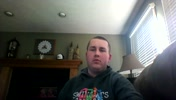

In [20]:
cv2_imshow(img)

In [21]:
# Ее класс
train['label'][0]

'Doing other things'

## Класс для кастомного датасета

In [22]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, dataframe):
        # Подаем наш подготовленный датафрейм
        self.dataframe = dataframe
        
        # Разделяем датафрейм на адреса картинок
        self.images_addr_arr = self.dataframe.iloc[:,7]
        # и номера классов
        self.class_index_arr = self.dataframe.iloc[:,3]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.dataframe.index)

    def __getitem__(self, index):
      result = torch.empty(1,3,128,128)
      #result = torch.empty(1,3,100,100)
      for image_addr in self.images_addr_arr[index]:
        # Читаем картинку и сразу же представляем ее в виде numpy-массива
        image = np.asarray(Image.open(image_addr)).astype('float')
        # Нормализуем изображение в значениях [0,1]
        image = torch.as_tensor(image)/255
        # Переставляем канал на 1-е место
        image = image.permute(2,0,1)
        # Добавляем батч измерение
        image = image.unsqueeze(0)
 
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 128x128
        # clamp не позволяет выйти за границы
        image = F.interpolate(input=image, size=128, align_corners=False, mode='bicubic').clamp(min=0, max=1)

        # Вариант 2: обрезаем лишнее с краев
        #center = int(image.shape[3]/2)
        #image = image[:,:,:,center-50:center+50]

        result = torch.cat((result, image), 0)
        
      # Читаем индекс класса 
      class_index = self.class_index_arr[index] 
      # Возвращаем без первого пустого тензора
      return (result[1:].float(), class_index)

    def __len__(self):
        return self.data_len

In [704]:
train_data = CustomDatasetFromImages(train)
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True)

## Проверка работы загрузчика

In [705]:
loader = iter(train_data_loader)
image, class_index = loader.next()
image = image.squeeze(0)

In [706]:
image.shape

torch.Size([32, 3, 128, 128])

In [707]:
class_index.shape

torch.Size([1])

In [708]:
class_index

tensor([2])

In [709]:
torch.unique(image).max()

tensor(1.)

In [710]:
torch.unique(image).min()

tensor(0.)

In [711]:
image.shape

torch.Size([32, 3, 128, 128])

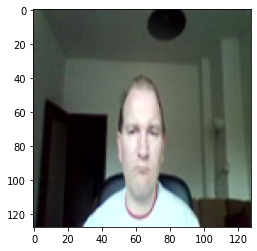

In [713]:
plt.imshow((image[24]).permute(1, 2, 0))
plt.show()

In [32]:
#for i in range(32):
#  plt.imshow((image[i]).permute(1, 2, 0))
#  plt.show()

In [714]:
# Выведем id класса
class_index[0].item()

2

In [715]:
# Выведем название класса
label_id_to_label.iloc[class_index[0].item()].values[0]

'No gesture'

## Создание класса модели

In [49]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [50]:
for param in resnet18.parameters():
    param.requires_grad = False

In [51]:
# Выведим количество параметров для тренировки
total_params = sum(p.numel() for p in resnet18.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,689,512 total parameters.
0 training parameters.


In [670]:
#resnet18

In [52]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [53]:
resnet18.fc = Identity()

In [145]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        for param in self.resnet18.parameters():
          param.requires_grad = False
        self.resnet18.fc = Identity()
        self.relu = nn.ReLU()
        self.gru = nn.GRU(input_size=512, hidden_size=128, batch_first=True)
        self.lstm = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.resnet18(x)
        x = x.unsqueeze(0)
        out, hidden = self.gru(x)
        #x = x[:,-1,:]
        x = self.fc1(hidden)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.squeeze(0)
        #print(out.shape)
        #print(hidden.shape)
        #print(out[0][-1])
        #print(hidden)
        return x

In [146]:
# Проверим правильность работы сети, прогнав через нее картинку
net = Net().to(device)
result = net(image.to(device))
result.shape

torch.Size([1, 3])

In [147]:
# Выведим количество параметров для тренировки
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,755,971 total parameters.
579,459 training parameters.


In [148]:
result

tensor([[ 0.1807, -0.0269, -0.3351]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [149]:
result = torch.argmax(result, dim=1)
result

tensor([0], device='cuda:0')

In [150]:
class_index

tensor([2])

In [151]:
float(torch.sum(result == class_index.to(device)).item())

0.0

## Обучение модели

In [152]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [156]:
epoch_losses = []
batch_size = 1
num_epochs = 30

for epoch in range(num_epochs):  
    train_loss = 0.0
    train_acc  = 0.0

    epoch_loss = []
    epoch_accuracy = []
    time1 = time.time()

    for batch_idx, data in enumerate(train_data_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs[0])
        loss = criterion(outputs, labels)
        accuracy = float(torch.sum(torch.argmax(outputs, dim=1) == labels).item())/batch_size
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy)
        if (batch_idx+1) % 100 == 99:
            print(f'Train Epoch: {epoch+1}, Train loss: {train_loss/100:.4f}, Train accuracy: {train_acc/100:.4f}')
            time2 = time.time()
            print(f'Spend time for 100 batches: {time2 - time1:.4f} sec')
            time1 = time.time()
            train_loss = 0.0
            train_acc  = 0.0

    epoch_losses.append(epoch_loss)
    torch.save(net, '/content/hand_model.pth')

print('Training is finished!')

Train Epoch: 1, Train loss: 0.9992, Train accuracy: 0.5400
Spend time for 100 batches: 16.9922 sec
Train Epoch: 1, Train loss: 1.0461, Train accuracy: 0.5000
Spend time for 100 batches: 17.1868 sec
Train Epoch: 1, Train loss: 1.0390, Train accuracy: 0.5100
Spend time for 100 batches: 17.2119 sec
Train Epoch: 1, Train loss: 0.9994, Train accuracy: 0.5600
Spend time for 100 batches: 17.2778 sec
Train Epoch: 1, Train loss: 0.9984, Train accuracy: 0.5600
Spend time for 100 batches: 17.2579 sec
Train Epoch: 1, Train loss: 0.9594, Train accuracy: 0.6000
Spend time for 100 batches: 17.2100 sec
Train Epoch: 1, Train loss: 1.0302, Train accuracy: 0.5400
Spend time for 100 batches: 17.1241 sec
Train Epoch: 1, Train loss: 1.0002, Train accuracy: 0.5600
Spend time for 100 batches: 17.2745 sec
Train Epoch: 1, Train loss: 0.9653, Train accuracy: 0.6000
Spend time for 100 batches: 17.1851 sec
Train Epoch: 1, Train loss: 1.0087, Train accuracy: 0.5500
Spend time for 100 batches: 17.1198 sec
Train Epoc

KeyboardInterrupt: ignored

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(1, 32, 128)
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x